# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


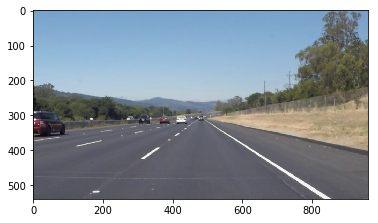

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, y_mask, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape = img.shape
    positive_slope = []
    positive_intercept = []
    negative_slope= []
    negative_intercept = [] 
    
    for line in lines:
        if line is not None:
            for x1,y1,x2,y2 in line:
                #Calculate slope & Intercept of the line in question (in lines)
                slope_int=(y2-y1)/float(x2-x1)
                intercept_int=np.mean([y1-(slope_int*x1),y2-(slope_int*x2)])
                #Future Expantion: Use the lenght of the line to calculate an weigthed average 
                #(i.e longer the line get more preference during averaging)
                #For the current scope, after reviewing the lines generated for the test images and videos, it looked like 
                #it would have had little affect, but in a world of "noise" I can see the benefit for future implimentation 
                length = math.sqrt(math.pow((x2-x1),2) + math.pow((y2-y1),2))
                #FOR DEBUG:
                #print(slope_int,intercept_int,length)
                
                #Future Expantion: Calibrated positive and negative slope ranges (for given scenario "path following"
                # and camera's focal parameters and mouting location). This could aid in rejection of false hits 
                # Sort into left or right lanes, Slope_p is the rigth lane, slope_n is the left lane 
                #(b/c on image coordinate system)
                if(slope_int>0):
                    positive_slope.append(slope_int)
                    positive_intercept.append(intercept_int)
                elif(slope_int<0):
                    negative_slope.append(slope_int)
                    negative_intercept.append(intercept_int)
                else:
                    pass
    #Calculate the average of all the lines in their respective categories (left or right)          
    slope_p = np.mean(positive_slope)
    intercept_p = np.mean(positive_intercept)
    slope_n = np.mean(negative_slope)
    intercept_n = np.mean(negative_intercept)
    
    #FOR DEBUG:
    #print(slope_p,intercept_p)
    #print(slope_n,intercept_n)
        
    #min y = y_mask (keep consistent with mask)
    #Filter out the "crazies"
    if (not math.isinf(slope_n)) and (not math.isnan(slope_n)) and (not math.isinf(intercept_n)) and (not math.isnan(intercept_n)):
        
            # Calculate the intersection of the lanes
            #intersect_x =(intercept_n-intercept_p)/(slope_p-slope_n)
            #intersect_y =int((slope_p*intersect_x) + intercept_p)
            
            #If the lanes intersects lower the drawn line to the intersection point
            #if (intersect_y > y_mask):
            #    y_mask = intersect_y
           
            #FOR DEBUG
            #print(intersect_x,intersect_y,y_mask)   
            
            x1 = int((imshape[0]-intercept_n)/slope_n)
            x2 = int((y_mask-intercept_n)/slope_n)
            cv2.line(img,(x1,imshape[0]),(x2,y_mask),(255,0,0),thickness)
            
    if (not math.isinf(slope_p)) and (not math.isnan(slope_p)) and (not math.isinf(intercept_p)) and (not math.isnan(intercept_p)):   
            x1 = int((imshape[0]-intercept_p)/slope_p)
            x2 = int((y_mask-intercept_p)/slope_p)
            cv2.line(img,(x1,imshape[0]),(x2,y_mask),(255,0,0),thickness)
      
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, y_mask):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, y_mask)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## FIND LANES

Find_lanes fuction is designed to accept an image and a flag indicator. Flag indicator is used for ploting images during the intermediate processes for debugging purposes.


In [5]:
def find_lanes(image,show):
    #covert image to grayscale
    
    #Convert image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    #Create upper and lower bounds for the white lines of the road
    #
    lower_white = np.array([0,0,200], dtype=np.uint8)
    upper_white = np.array([255,55,255], dtype=np.uint8)
    
    mask1 = cv2.inRange(hsv, lower_white, upper_white)

    lower_yellow = np.array([75,100,100], dtype=np.uint8)
    upper_yellow = np.array([100,255,255], dtype=np.uint8)

    mask2 = cv2.inRange(hsv, lower_yellow, upper_yellow)

    maskF = mask1 + mask2
    
    #Extract yellow and white out of the image
    res = cv2.bitwise_and(image,image, mask= maskF)
    
    gray = grayscale(res)
    
    if (show == 1):
    #For testing and debug processes ##TODO Comment out for video
        plt.figure()
        plt.subplot(2,3,1)
        plt.imshow(gray, cmap ="gray")
    
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    if (show == 1):
        plt.subplot(2,3,2)
        plt.imshow(gray, cmap ="gray")
    
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    if (show == 1):
        plt.subplot (2,3,3)
        plt.imshow(edges)   
    
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #print(int(image.shape[0]*0.6))
    ##TODO calculate the y_mask, x_mask_min,x_mask_max based on perspective geometry (.i.e.vanishing point)
    ##However, might be better to implement on a side "callibration process"
    y_mask = int(image.shape[0]*0.6)
    x_mask_min = int(image.shape[1]*0.42)
    x_mask_max = int(image.shape[1]*0.57)
    x_mask_edge = int(image.shape[1]*0.13)
    #print(y_mask,x_mask_min,x_mask_max,x_mask_edge)
    
    ##TODO calculate after running once, 
    ##replace 0 <-- lane_left x intersection[imshape[0]] - buffer
    ##replace imshape[1] <-- right_left x intersection[imshape[0]] + buffer
   
    vertices = np.array([[(x_mask_edge,imshape[0]),(x_mask_min, y_mask), (x_mask_max, y_mask), (imshape[1]-x_mask_edge,imshape[0])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges,vertices)
    
    if (show == 1):
        plt.subplot (2,3,4)
        plt.imshow(masked_edges)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40  #minimum number of pixels making up a line
    max_line_gap = 30 # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, y_mask)
    
    if (show == 1):
        plt.subplot (2,3,5)
        plt.imshow(lines)
    
    final = weighted_img(image,lines)
    
    if (show == 1):
        plt.subplot (2,3,6)
        plt.imshow(final)
    
    return final

Wall time: 711 ms
Wall time: 708 ms
Wall time: 763 ms
Wall time: 688 ms
Wall time: 689 ms
Wall time: 815 ms


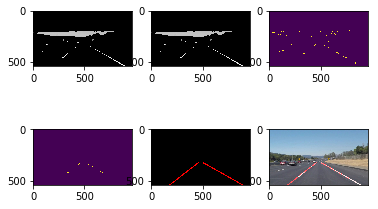

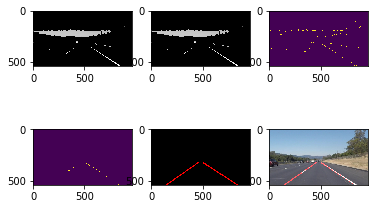

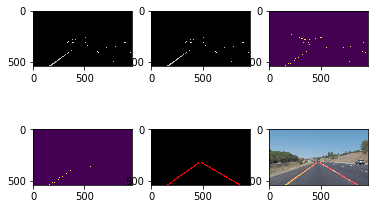

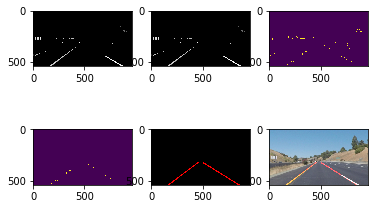

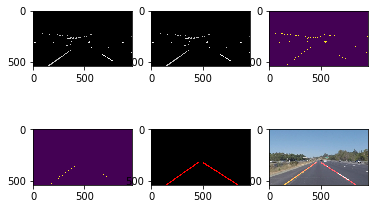

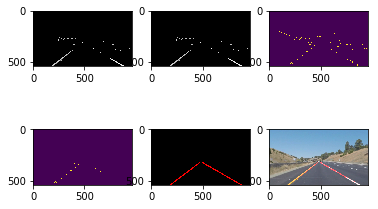

In [6]:
for img in os.listdir("test_images/"):
    image_path = os.path.join("test_images/",img)
    output_path = os.path.join("test_images_output/",img)
    image = mpimg.imread(image_path)
    %time final = find_lanes(image,1)
    mpimg.imsave(output_path,final)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result=find_lanes(image,0)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████▋| 221/222 [00:11<00:00, 19.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 12 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████▉| 681/682 [00:23<00:00, 29.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 24 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 15.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 16.5 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Reflection 

## My Pipeline

My Pipeline consists of the following steps: 

In the function Find_lanes 

### Step 1. 

Extract an Image that only had 2 colours (yellow and white) from original image. This helps narrow down the data to the main colours associated with the lanes.

I used cv2.inRage to create 2 masks. 

Mask 1 was for the color white which was in the HSV range of the [0,0,200] to [255,55,255]. This specifies the center of the HSV wheel with a radius of 55.

Mask 2 was for the color yellow which was in the HSV range of the [75,100,200] to [100,255,255]. Which specifies the hue in the range of 75-100. 

After that I added the two masks together I was able to extract the an image with only yellow and white, using the cv2.bitwise function.

### Step 2. 

After I create colour masked images I converted it into the a grayscale image for further processing.

### Step 3. 

Then using the Gaussian blur function, I smoothed the image with a kernel of 5. 

### Step 4.
Apply Canny filter to extract the high gradient areas that fall within the threshold window. I specified a low threshold of 50 and a high value of 150. These values seem to give the best results. During my finetuning I tied a variety of combinations from an upper bound of 200 and a lower bound of 20. 

### Step 5. 

Calculate the parameter of the mask, based on the resolution of the image. Using the resolution of the image I calculate the vertices of the mask by scaling the values I found worked well on the 540 X 960 images to any resolution (for the challenge video) 

### Step 6. 
Apply the mask to remove all the edges that do not lie within my expected lane area on the image

### Step 7. 

Find the hough lines for the given parameters. I played with these parameters quite a bit trying to optimise the line detection. In the end I settled with these values that worked reasonable well. 

### Step 8. 

After extracting the lines from the hough_lines function pass to the draw lines function. 

In the draw_lines function
For every line I calculated the slope, intercept and length. Then I sorted the slopes and intercepts of each line based on the value of the sole. If the slope was greater than Zero (+) then put that into the positive slope array, and if the slope was smaller (-) the put into negative slope array . If slope equaled zero, ignore it. 

Then using the np.mean function I calculated the average of 2 categories (positive lines and negative lines).

Positive lines representing the right lane 

Negative liens representing the left lane.

With the averaged slope & intercept of the positive line I used the cv2.line function to draw the right lane from the bottom of the image (y=max) (x is calculated based on equation on line) to the y = mask height.

Similarly, with the averaged slope & intercept of the negative line
and draw the left lane for the same y values as above. 

### Step 9

Add lines to original image using the weighted image function and output final result.


## Potential Shortcomings

In Step 1, I masked the image to extract the 2 colours yellow and white to aid the edge detection and "narrow down" the search. But I noticed I started to get less lines when tracking the segmented lanes, resulting in a "choppy" tracking. Potentially because of the range not specified optimally. Also, I can see this failing my pipeline on old weathered roads where the lanes are no longer white or yellow anymore.

In Step 7, I finalized my parameters for the hough_lines function through trial and error. Ideally given time, I would map out my accuracy "of the lane" finding for a range of each parameter, and through a error cost function find my optimal parameters for this scheme.

In Step 8, I calculated the line of each lane by averaging the slopes of the positive and negative lines. I this introduces error because one the length of the line was not taken into account, so very small lines (potentially wrong or misidentified) have the same weight as the longer lines. 


## Improvements 
If we could create a camera calibration process where we could calculate the focal parameters of the camera and the expected lane geometry for the camera's mount location. We could calculate a robust mask for out Region of Interest and "Expected" range of viable slopes that can be used to reject lines caused but noise (tire skid marks, pavement construction lines etc.). (this is assuming that this measurement scheme is only used to stay within two lanes, and that the heading of the car is expected to stay center of the lanes. No turning into a lane etc.)

To reduce the error in Step 8, after we calculate the slopes to classify the hough lines into the 2 groups of right (positive) and left lanes (negative). Run the associated x,y points through a linear regression to find the line of best fit for each lane. 
